In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import scipy.stats
import pdb

from torch.utils.data import TensorDataset, DataLoader, SequentialSampler
from skorch import NeuralNetRegressor
from IPython.display import display
from sklearn.metrics.regression import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

%matplotlib inline

# Convolutional Neural Network for Time Series

## Univariate CNN 

Univarate time series are datasets contains only one sinle series of observations with a temporal ordering. Model need to learn from past observations to predict next value in sequence.

### Dataset

Monthly sunspot dataset describes a monthly count of number of observed sunspots for just over 230 years from 1749 to 1983. Dataset contains 2820 observations. 

You can download data from: https://datamarket.com/data/set/22ti/zuerich-monthly-sunspot-numbers-1749-1983#!ds=22ti&display=line

In [2]:
uni_df = pd.read_csv('datasets/zuerich-monthly-sunspot-numbers-.csv', 
                     sep=';', names=['month', 'observations'], header=0)
uni_df.dropna(inplace=True)
uni_df['month'] = pd.to_datetime(uni_df['month'])
uni_df.set_index('month', inplace=True)
uni_df.head(5)

,observations
month,
1749-01-01,58.0
1749-02-01,62.6
1749-03-01,70.0
1749-04-01,55.7
1749-05-01,85.0


In [3]:
uni_df.shape

(2820, 1)

In [4]:
uni_df.dtypes

observations    float64
dtype: object

The time series is univariate, it can be easly plotted.

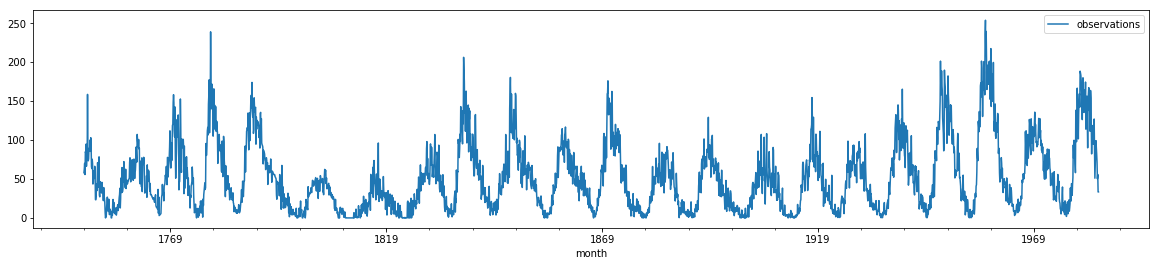

In [5]:
uni_df.plot(figsize=(20, 4))

### Data preparation

PyTorch provides tool for preparing data. It makes code more readable and reusable. 

In [6]:
def make_sequence(series, window):
    X, y = list(), list()
    size = len(series)
    for i in range(size):
        end_ix = i + window
        if end_ix > size - 1:
            break
        seq_x, seq_y = series[i:end_ix], series[end_ix]
        X.append(seq_x)
        y.append(seq_y)

    return (np.array(X, dtype=np.float32), np.array(y, dtype=np.float32))

def prepare_dataset(series, window):
    X, y = make_sequence(series, window)
    return torch.from_numpy(X), torch.from_numpy(y)

In [7]:
threshold_month = '1939-11-01'
window = 10
D_in = window

X_train, y_train = prepare_dataset(uni_df[uni_df.index <= threshold_month].values, window)
X_test, y_test = prepare_dataset(uni_df[uni_df.index > threshold_month].values, window)

# Normalize
# @TODO

Data set needs to be splitted to train and test sets. Torch has good tool from sampling 

In [8]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

### One-Dimensional Convolutional Neural Network Model (1D CNN)

1D CNN is a model that has convolutional hidden layer that calculates over one dimensional sequence. 

Select device.

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
assert device.type == 'cuda'

print(torch.cuda.get_device_name(0))

GeForce GTX 1060


In [10]:
class OneDCNN(nn.Module):
    def __init__(self, n_features, n_hidden, n_output):
        super(OneDCNN, self).__init__()
        self.n_features = n_features
        self.cnn = nn.Sequential(
            nn.Conv1d(n_features, n_hidden, 3, padding=3),
            nn.MaxPool1d(5)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(n_hidden, 32)
        )
        self.fc2 = nn.Linear(32, n_output)

    def forward(self, x):
        size = x.size(0)
        x = x.contiguous()
        x = x.view(size, self.n_features, 1)

        x = self.cnn(x)
        x = x.view(size, -1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x
        
one_dcnn = OneDCNN(10, 128, 1).to(device)
one_dcnn

OneDCNN(
  (cnn): Sequential(
    (0): Conv1d(10, 128, kernel_size=(3,), stride=(1,), padding=(3,))
    (1): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=128, out_features=32, bias=True)
  )
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)

Define a loss function and optimizer.

In [11]:
criterion = nn.MSELoss()
optimizer = optim.Adam(one_dcnn.parameters(), lr=0.0001, weight_decay=0.01, amsgrad=True)

Prepare train and test dataloader.

In [12]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=False, drop_last=True, num_workers=8, sampler=SequentialSampler(train_dataset))
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, drop_last=False, num_workers=8, sampler=SequentialSampler(test_dataset))

Train network

In [ ]:
one_dcnn.train()
n_epoch = 30
loss_history = list()
for epoch in range(n_epoch):
    running_loss = 0.0
    for i, data in enumerate(train_loader):
#         pdb.set_trace()
        inputs, targets = data
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = one_dcnn(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    print('[%d] loss: %.3f' % (epoch + 1, running_loss / i))
    loss_history.append(running_loss )

The plot below shows loss error.

In [ ]:
plt.plot(np.log(loss_history));

Validate the network

Predict new observations

In [152]:
one_dcnn.eval()
test_loss = 0
correct = 0
predictions = list()
features = list()
_targets = list()
with torch.no_grad():
    for data, targets in test_loader:
        features.extend(list(data.to('cpu').numpy()))
        predictions.extend(list(one_dcnn(data.to(device)).to('cpu').numpy()))
        _targets.extend(list(targets.to(device).to('cpu').numpy()))
        
predictions = np.array(predictions)
targets = np.array(_targets)
features  = np.array(features)

The plot shows observations and predictions for testing period.

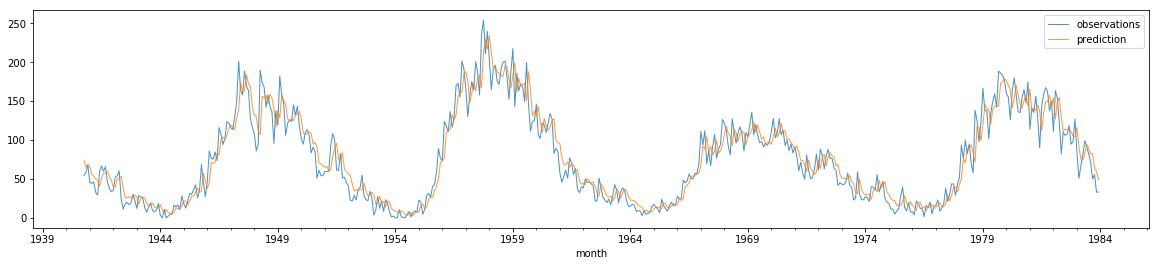

In [153]:
test_df = uni_df[uni_df.index > threshold_month].loc['1940-10-01':, :]
test_df.loc[:, 'features'] = list(map(lambda x: ', '.join(map(lambda x: str(x[0]), x)), features))
test_df['prediction'] = predictions
test_df['prediction'] = test_df['prediction']
test_df.drop('features', axis=1).plot(figsize=(20, 4), lw=1, alpha=0.8)

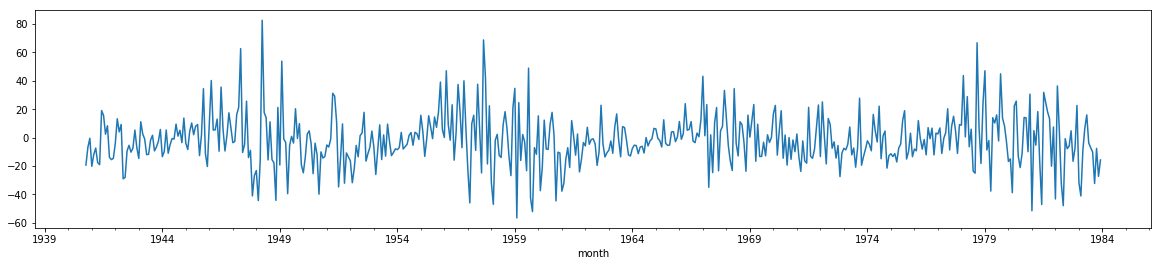

In [154]:
test_df['error'] = test_df['observations'] - test_df['prediction']
test_df.error.plot(figsize=(20, 4))

Check the hightest errors.

In [144]:
pd.set_option('display.max_colwidth', -1)
display(test_df.sort_values('error', ascending=False).head(10))

,observations,features,prediction,error
month,,,,
1948-04-01,189.7,"163.9, 157.9, 188.8, 169.4, 163.6, 128.0, 116.5, 108.5, 86.1, 94.8",107.520927,82.179073
1957-09-01,235.8,"201.3, 192.1, 165.0, 130.2, 157.4, 175.2, 164.6, 200.7, 187.2, 158.0",164.658707,71.141293
1978-09-01,138.2,"29.1, 43.2, 51.9, 93.6, 76.5, 99.7, 82.7, 95.1, 70.4, 58.1",70.398575,67.801425
1947-05-01,201.3,"116.2, 107.2, 94.4, 102.3, 123.8, 121.7, 115.7, 113.4, 129.8, 149.8",135.964462,65.335538
1949-02-01,182.3,"189.7, 174.0, 167.8, 142.2, 157.9, 143.3, 136.3, 95.8, 138.0, 119.1",129.244186,53.055814
1959-08-01,199.6,"181.5, 152.3, 187.6, 217.4, 143.1, 185.7, 163.3, 172.0, 168.7, 149.6",149.501617,50.098383
1979-01-01,166.6,"76.5, 99.7, 82.7, 95.1, 70.4, 58.1, 138.2, 125.1, 97.9, 122.7",116.624481,49.975519
1979-09-01,188.4,"97.9, 122.7, 166.6, 137.5, 138.0, 101.5, 134.4, 149.5, 159.4, 142.2",140.437347,47.962653
1956-02-01,124.0,"11.3, 28.9, 31.7, 26.7, 40.7, 42.7, 58.5, 89.2, 76.9, 73.6",76.775032,47.224968


In [121]:
mean_absolute_error(test_df.observations, test_df.prediction), r2_score(test_df.observations, test_df.prediction)

(13.697183091286751, 0.8941298122603247)

In [155]:
mean_absolute_error(test_df.observations, test_df.prediction), r2_score(test_df.observations, test_df.prediction)              

(13.780092683876642, 0.8930752674246456)